In [1]:
import os
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
from pyHalo.preset_models import preset_model_from_name

from mejiro.galaxy_galaxy import SampleBELLS, SampleSL2S, SampleGG
from mejiro.instruments.roman import Roman
from mejiro.instruments.hwo import HWO
from mejiro.synthetic_image import SyntheticImage
from mejiro.utils import util

Warning, 5 of 20000 bins contained negative fluxes; they have been set to zero.


/data/bwedig/.conda/envs/mejiro-v2/lib/python3.10/site-packages/pysynphot/units.py:824: RuntimeWarning: divide by zero encountered in log
  return -1.085736 * N.log(arg) + ABZERO


Warning, 3590 of 20000 bins contained negative fluxes; they have been set to zero.
Warning, 293 of 2920 bins contained negative fluxes; they have been set to zero.


In [2]:
num_samples = 100

In [3]:
strong_lens = SampleGG()
log_main_halo_mass = 13.8  # np.log10(strong_lens.get_main_halo_mass())
log_mlow = 6
log_mhigh = 11

In [4]:
CDM = preset_model_from_name('CDM')

cdm_realizations = []
for i in tqdm(range(num_samples)):
    cdm_realization = CDM(round(strong_lens.z_lens, 2), 
                          round(strong_lens.z_source, 2), 
                          cone_opening_angle_arcsec=5, 
                          log_m_host=log_main_halo_mass,
                          log_mlow=log_mlow,
                          log_mhigh=log_mhigh)
    cdm_realizations.append(cdm_realization)

100%|██████████| 100/100 [00:34<00:00,  2.86it/s]


In [5]:
WDM = preset_model_from_name('WDM')

wdm_7_realizations, wdm_8_realizations, wdm_9_realizations = [], [], []
for i in tqdm(range(num_samples)):
    wdm_7_realization = WDM(round(strong_lens.z_lens, 2), 
                            round(strong_lens.z_source, 2), 
                            log_mc=7, 
                            cone_opening_angle_arcsec=5, 
                            log_m_host=log_main_halo_mass,
                          log_mlow=log_mlow,
                          log_mhigh=log_mhigh)
    wdm_8_realization = WDM(round(strong_lens.z_lens, 2), 
                            round(strong_lens.z_source, 2), 
                            log_mc=8, 
                            cone_opening_angle_arcsec=5, 
                            log_m_host=log_main_halo_mass,
                          log_mlow=log_mlow,
                          log_mhigh=log_mhigh)
    wdm_9_realization = WDM(round(strong_lens.z_lens, 2), 
                            round(strong_lens.z_source, 2), 
                            log_mc=9, 
                            cone_opening_angle_arcsec=5, 
                            log_m_host=log_main_halo_mass,
                          log_mlow=log_mlow,
                          log_mhigh=log_mhigh)
    wdm_7_realizations.append(wdm_7_realization)
    wdm_8_realizations.append(wdm_8_realization)
    wdm_9_realizations.append(wdm_9_realization)

100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


In [6]:
SIDM = preset_model_from_name('SIDM_core_collapse')

mass_ranges_subhalos = [[log_mlow, 7.0], [7.0, 8.0], [8.0, 9.0], [9.0, log_mhigh]]
mass_ranges_field_halos = [[6.0, 7.5], [7.5, 8.5], [8.5, 10.0]]
collapse_fraction_subhalos = [0.9, 0.7, 0.5, 0.2]
collapse_fraction_fieldhalos = [0.3, 0.2, 0.1]

sidm_realizations = []
for i in tqdm(range(num_samples)):
    sidm_realization = SIDM(round(strong_lens.z_lens, 2), 
                    round(strong_lens.z_source, 2), 
                    mass_ranges_subhalos, 
                    mass_ranges_field_halos, 
                    collapse_fraction_subhalos, 
                    collapse_fraction_fieldhalos, 
                    cone_opening_angle_arcsec=5, 
                    log_m_host=log_main_halo_mass)
    sidm_realizations.append(sidm_realization)

100%|██████████| 100/100 [00:36<00:00,  2.75it/s]


In [7]:
ULDM = preset_model_from_name('ULDM')

uldm_20_realizations, uldm_21_realizations = [], []
for i in tqdm(range(num_samples)):
    uldm_20_realization = ULDM(round(strong_lens.z_lens, 2), 
                        round(strong_lens.z_source, 2), 
                        log10_m_uldm=-20,
                        cone_opening_angle_arcsec=5, 
                        log_m_host=log_main_halo_mass,
                        flucs_shape='ring',
                        flucs_args={'angle': 0.0, 'rmin': 0.9, 'rmax': 1.1},
                        log10_fluc_amplitude=-1.6, 
                        n_cut=1000000,
                          log_mlow=log_mlow,
                          log_mhigh=log_mhigh)
    uldm_21_realization = ULDM(round(strong_lens.z_lens, 2), 
                        round(strong_lens.z_source, 2), 
                        log10_m_uldm=-21,
                        cone_opening_angle_arcsec=5, 
                        log_m_host=log_main_halo_mass,
                        flucs_shape='ring',
                        flucs_args={'angle': 0.0, 'rmin': 0.9, 'rmax': 1.1},
                        log10_fluc_amplitude=-1.6, 
                        n_cut=1000000,
                          log_mlow=log_mlow,
                          log_mhigh=log_mhigh)
    uldm_20_realizations.append(uldm_20_realization)
    uldm_21_realizations.append(uldm_21_realization)

100%|██████████| 100/100 [19:27<00:00, 11.67s/it]


In [8]:
def get_bins_mean_std(realizations, num_bins):
    count_list = []

    for realization in realizations:
        cdm_halo_masses = [halo.mass for halo in realization.halos]
        count, bins = np.histogram(cdm_halo_masses, bins=np.logspace(log_mlow, log_mhigh, num_bins))
        count_list.append(count)

    return bins[:-1], np.mean(count_list, axis=0), np.std(count_list, axis=0)

bins = 20
bins_cdm_shmf, mean_cdm_shmf, std_cdm_shmf = get_bins_mean_std(cdm_realizations, bins)
bins_wdm_7_shmf, mean_wdm_7_shmf, std_wdm_7_shmf = get_bins_mean_std(wdm_7_realizations, bins)
bins_wdm_8_shmf, mean_wdm_8_shmf, std_wdm_8_shmf = get_bins_mean_std(wdm_8_realizations, bins)
bins_wdm_9_shmf, mean_wdm_9_shmf, std_wdm_9_shmf = get_bins_mean_std(wdm_9_realizations, bins)
bins_sidm_shmf, mean_sidm_shmf, std_sidm_shmf = get_bins_mean_std(sidm_realizations, bins)
bins_uldm_20_shmf, mean_uldm_20_shmf, std_uldm_20_shmf = get_bins_mean_std(uldm_20_realizations, bins)
bins_uldm_21_shmf, mean_uldm_21_shmf, std_uldm_21_shmf = get_bins_mean_std(uldm_21_realizations, bins)

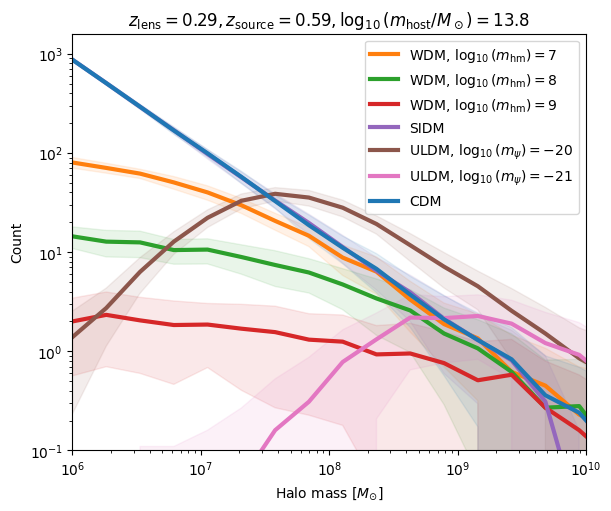

In [16]:
f, ax = plt.subplots(1, 1, figsize=(6, 5), constrained_layout=True)

linewidth = 3.
std_alpha = 0.1
cdm_color = 'C0'
wdm_7_color = 'C1'
wdm_8_color = 'C2'
wdm_9_color = 'C3'
sidm_color = 'C4'
uldm_20_color = 'C5'
uldm_21_color = 'C6'

ax.loglog(bins_wdm_7_shmf, mean_wdm_7_shmf, 
          alpha=1., label=r'WDM, $\log_{10}(m_{\text{hm}})=7$', color=wdm_7_color, linewidth=linewidth)
ax.fill_between(bins_wdm_7_shmf, mean_wdm_7_shmf - std_wdm_7_shmf, mean_wdm_7_shmf + std_wdm_7_shmf,
                alpha=std_alpha, color=wdm_7_color)

ax.loglog(bins_wdm_8_shmf, mean_wdm_8_shmf, 
          alpha=1., label=r'WDM, $\log_{10}(m_{\text{hm}})=8$', color=wdm_8_color, linewidth=linewidth)
ax.fill_between(bins_wdm_8_shmf, mean_wdm_8_shmf - std_wdm_8_shmf, mean_wdm_8_shmf + std_wdm_8_shmf,
                alpha=std_alpha, color=wdm_8_color)

ax.loglog(bins_wdm_9_shmf, mean_wdm_9_shmf, 
          alpha=1., label=r'WDM, $\log_{10}(m_{\text{hm}})=9$', color=wdm_9_color, linewidth=linewidth)
ax.fill_between(bins_wdm_9_shmf, mean_wdm_9_shmf - std_wdm_9_shmf, mean_wdm_9_shmf + std_wdm_9_shmf,
                alpha=std_alpha, color=wdm_9_color)

ax.loglog(bins_sidm_shmf, mean_sidm_shmf, 
          alpha=1., label=r'SIDM', color=sidm_color, linewidth=linewidth)
ax.fill_between(bins_sidm_shmf, mean_sidm_shmf - std_sidm_shmf, mean_sidm_shmf + std_sidm_shmf, 
                alpha=std_alpha, color=sidm_color)

ax.loglog(bins_uldm_20_shmf, mean_uldm_20_shmf, 
          alpha=1., label=r'ULDM, $\log_{10}(m_\psi)=-20$', color=uldm_20_color, linewidth=linewidth)
ax.fill_between(bins_uldm_20_shmf, mean_uldm_20_shmf - std_uldm_20_shmf, mean_uldm_20_shmf + std_uldm_20_shmf,
                alpha=std_alpha, color=uldm_20_color)

ax.loglog(bins_uldm_21_shmf, mean_uldm_21_shmf, 
          alpha=1., label=r'ULDM, $\log_{10}(m_\psi)=-21$', color=uldm_21_color, linewidth=linewidth)
ax.fill_between(bins_uldm_21_shmf, mean_uldm_21_shmf - std_uldm_21_shmf, mean_uldm_21_shmf + std_uldm_21_shmf,
                alpha=std_alpha, color=uldm_21_color)

ax.loglog(bins_cdm_shmf, mean_cdm_shmf, 
          alpha=1., label=r'CDM', color=cdm_color, linewidth=linewidth)
ax.fill_between(bins_cdm_shmf, mean_cdm_shmf - std_cdm_shmf, mean_cdm_shmf + std_cdm_shmf, 
                alpha=std_alpha, color=cdm_color)

# ax.axvline(10**8.8, color='k', linestyle='--', linewidth=1, label='Euclid')
# ax.axvline(10**9, color='k', linestyle='--', linewidth=1, label='HST, Roman')

ax.set_xlabel('Halo mass [' + r'$M_{\odot}$]')
ax.set_xticks([1e6, 1e7, 1e8, 1e9, 1e10])
ax.set_ylabel('Count')

ax.set_xlim(left=1e6, right=1e10)
ax.set_ylim(bottom=1e-1)

plt.legend()
plt.title(r'$z_{\text{lens}}=0.29, z_\text{source}=0.59, \log_{10}(m_{\text{host}}/M_\odot)=13.8$')
plt.savefig('/grad/bwedig/mejiro/projects/hwo/figures/fig_1.png', dpi=600)
plt.show()